# C-mix model tutorial

In [1]:
%reset -f
%matplotlib inline
%load_ext rpy2.ipython
import numpy as np
import pylab as pl
import pandas as pd
from QNEM.inference import QNEM
from QNEM.simulation import CensoredGeomMixtureRegression
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from time import time
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
## Choose parameters ##
n_samples = 1000          # number of patients
n_features = 100          # number of features
n_active_features = 30    # number of active features
K = 1.                    # value of the active coefficients 
gap = .1                  # gap value to create high/low risk groups
rho = 0.5                 # coefficient of the toeplitz correlation matrix
r_cf = .5                 # confusion factors rate 
r_c = 0.5                 # censoring rate
pi0 = 0.75                # proportion of desired low risk patients rate
p0 = .01                  # geometric parameter for low risk patients
p1 = 0.5                  # geometric parameter for high risk patients
verbose = True            # verbose mode to detail or not ongoing tasks

simu = CensoredGeomMixtureRegression(verbose, n_samples, n_features,
                                     n_active_features, K, rho, pi0,
                                     gap, r_c, r_cf, p0, p1)
X, Y, delta = simu.simulate()

-----------------------------------------------------------
Launching simulation using CensoredGeomMixtureRegression...
Done simulating using CensoredGeomMixtureRegression in 2.03e-01 seconds.


## Data splitting

In [3]:
## Assign index for each feature ##
features_names = range(X.shape[1]) 
n_samples, n_features = X.shape

## Split data into training and test sets ##
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    delta_test = delta[test_index]
    Y_test = Y[test_index]

    X = X[train_index]
    Y = Y[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Training 

In [4]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
fit_intercept = True  # whether or not an intercept term is fitted
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'
verbose = True 

## Choose between C-mix or CURE model ##
model = "C-mix"  # "C-mix", "CURE"       

if verbose:
    print("\nLaunching %s...\n" % model)

learner = QNEM(l_elastic_net=0., eta=eta, max_iter=100, tol=tol, 
               warm_start=warm_start, verbose=verbose, model=model, 
               fit_intercept=fit_intercept)
learner.n_features = n_features         

## Cross-validation ##
learner.cross_validate(X, Y, delta, n_folds=5, verbose=False, eta=eta, 
                       grid_size=grid_size, metric=metric)
avg_scores = learner.scores.mean(axis=1)
l_elastic_net_best = learner.l_elastic_net_best
if gamma_chosen == '1se':
    l_elastic_net_chosen = learner.l_elastic_net_chosen
if gamma_chosen == 'min':
    l_elastic_net_chosen = l_elastic_net_best
    
grid_elastic_net = learner.grid_elastic_net # get the cross-validation grid 
                                            # to plot learning curves

## Run selected model with l_elasticNet_chosen ##
learner = QNEM(l_elastic_net=l_elastic_net_chosen, eta=eta, tol=tol,
               warm_start=warm_start, verbose=verbose, model=model,
               fit_intercept=fit_intercept)
learner.n_features = n_features
learner.fit(X, Y, delta)  


Launching C-mix...

Testing l_elastic_net=6.18e-05 on fold  0 1 2 3 4: avg_score=8.05e-01
Testing l_elastic_net=8.49e-05 on fold  0 1 2 3 4: avg_score=8.03e-01
Testing l_elastic_net=1.17e-04 on fold  0 1 2 3 4: avg_score=8.02e-01
Testing l_elastic_net=1.60e-04 on fold  0 1 2 3 4: avg_score=8.03e-01
Testing l_elastic_net=2.20e-04 on fold  0 1 2 3 4: avg_score=7.97e-01
Testing l_elastic_net=3.02e-04 on fold  0 1 2 3 4: avg_score=8.12e-01
Testing l_elastic_net=4.15e-04 on fold  0 1 2 3 4: avg_score=8.11e-01
Testing l_elastic_net=5.70e-04 on fold  0 1 2 3 4: avg_score=8.07e-01
Testing l_elastic_net=7.84e-04 on fold  0 1 2 3 4: avg_score=8.21e-01
Testing l_elastic_net=1.08e-03 on fold  0 1 2 3 4: avg_score=8.16e-01
Testing l_elastic_net=1.48e-03 on fold  0 1 2 3 4: avg_score=8.23e-01
Testing l_elastic_net=2.03e-03 on fold  0 1 2 3 4: avg_score=8.27e-01
Testing l_elastic_net=2.79e-03 on fold  0 1 2 3 4: avg_score=8.27e-01
Testing l_elastic_net=3.84e-03 on fold  0 1 2 3 4: avg_score=8.33e-01

## Prediction

In [5]:
## Obtain the marker vector on test set ##
coeffs = learner.coeffs
marker = QNEM.predict_proba(X_test, fit_intercept, coeffs) 
c_index = c_index_score(Y_test, delta_test, marker)
c_index = max(c_index, 1 - c_index)

print("Done predicting on test set.")
print("C-index : %.2f" % c_index)

Done predicting on test set.
C-index : 0.66


## Figures

### Learning curves

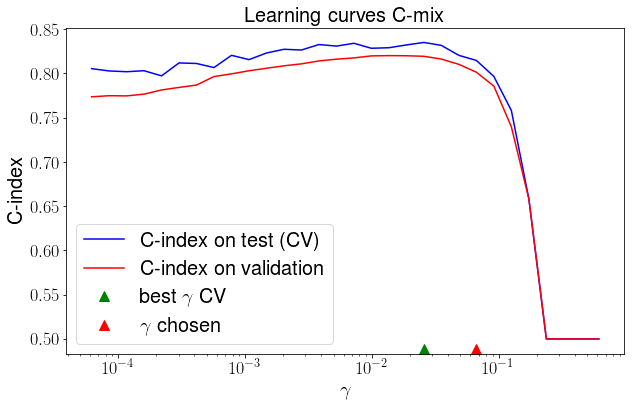

In [6]:
## Display learning curves ##
score_test = []
for idx_elastic_net, l_elastic_net in enumerate(grid_elastic_net):
    learner_ = QNEM(verbose=False, l_elastic_net=l_elastic_net,
                    eta=eta, warm_start=warm_start, tol=tol, model=model,
                    fit_intercept=fit_intercept)
    learner_.n_features = n_features
    learner_.fit(X, Y, delta)
    if metric == 'log_lik':
        pc_ = 1. / np.mean(T[delta == 0])
        score_ = learner_._log_lik(X_test, Y_test, delta_test)              
    if metric == 'C-index':
        marker_ = QNEM.predict_proba(X_test, fit_intercept, learner_.coeffs)
        score_ = c_index_score(Y_test, marker_, delta_test) 
    score_test.append(score_)

fig = pl.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
ax.plot(grid_elastic_net, avg_scores, '-b', label=metric + ' on test (CV)')
pl.xscale('log')
ax.plot(grid_elastic_net, score_test, '-r', label=metric + ' on validation')
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max])
ax.plot(l_elastic_net_best, y_min, 'g^', ms=20, label='best $\gamma$ CV')
ax.plot(l_elastic_net_chosen, y_min, 'r^', ms=20, label='$\gamma$ chosen')
pl.title("Learning curves %s" % model, fontsize=20)
pl.xlabel('$\gamma$', fontsize=20)
pl.ylabel(metric, fontsize=20)
pl.xticks(fontsize = 18)
pl.yticks(fontsize = 18)
pl.legend(numpoints=1, markerscale=.5, fontsize=20)
pl.show()

### Convergence

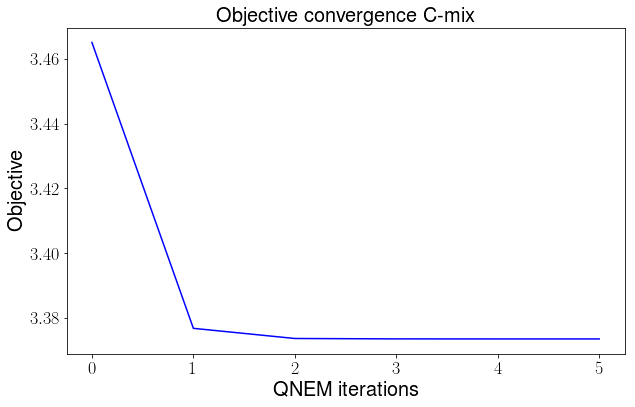

In [7]:
pl.figure(figsize=(10, 6))
pl.title("Objective convergence %s" % model, fontsize=20)
pl.xlabel('QNEM iterations', fontsize=20)
pl.ylabel('Objective', fontsize=20)
pl.xticks(fontsize = 18)
pl.yticks(fontsize = 18)
pl.plot(learner.get_history("n_iter"), learner.get_history("obj"), '-b')
pl.show()

### Beta coefficients

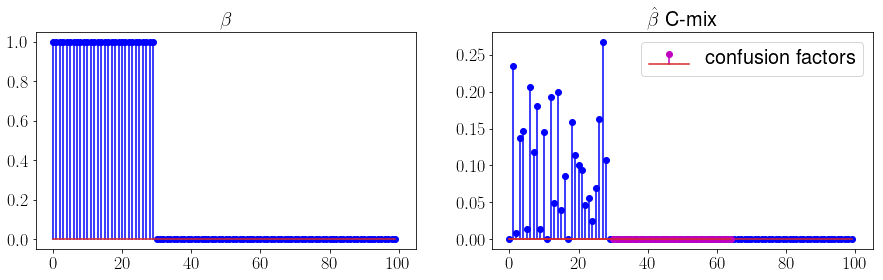

In [8]:
## True beta ##
beta = np.zeros(n_features)
beta[0:n_active_features] = K
fig = pl.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax1.stem(beta, linefmt='b-', markerfmt='bo')
ax1.set_xlim([-5, len(beta) + 5])
ax1.set_title(r"$\beta$", fontsize=20)
pl.xticks(fontsize = 18)
pl.yticks(fontsize = 18)

## Beta estimate ##
if fit_intercept:
    coeffs = -coeffs[1:]
ax2 = fig.add_subplot(122)
ax2.stem(coeffs, linefmt='b-', markerfmt='bo')
cf_end = n_active_features + int((n_features-n_active_features) * r_cf)
coeffs_cf = coeffs[n_active_features:cf_end]
coeffs_cf = np.append(np.repeat([np.nan], n_active_features), coeffs_cf)
ax2.stem(coeffs_cf, linefmt='m-', markerfmt='mo', label='confusion factors')
ax2.set_xlim([-5, len(coeffs) + 5])
ax2.set_title(r"$\hat \beta$ %s" % model, fontsize=20)
pl.xticks(fontsize = 18)
pl.yticks(fontsize = 18)
pl.legend(fontsize=20)
pl.show()